# Preliminary Data Exploration
### Heart Rates Dataset

##### 1. Verify the Structure

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
# load all files with a date less or equal to 2025-01-06
directory = "../../data/raw/heart_rates"
limit_date = pd.to_datetime("2025-01-06", format="%Y-%m-%d")
filtered_files = [f for f in os.listdir(directory) if (f.endswith(".csv") and pd.to_datetime(f.split(".")[0], format="%Y-%m-%d") <= limit_date)]

files = [
    os.path.join(directory, f) for f in filtered_files
]


print(f"Number of files: {len(files)}")

Number of files: 17


In [4]:
# load a sample file
sample_file = files[3]
print(f"Sample file: {sample_file}")

Sample file: ../../data/raw/heart_rates\2024-12-24.csv


In [5]:
sample_df = pd.read_csv(sample_file)

print("Sample file structure:")
print(sample_df.info())
print("\nFirst rows of the sample file:")
sample_df.head()

Sample file structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   timestamp   720 non-null    object
 1   heart_rate  720 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB
None

First rows of the sample file:


,timestamp,heart_rate
0,00:00,75
1,00:02,75
2,00:04,66
3,00:06,75
4,00:08,83


In [6]:
# extend the structure verify to all datasets
all_files_valid = True

for file in files:
    df = pd.read_csv(file)

    if not set(['timestamp', 'heart_rate']).issubset(df.columns):
        print(f"Missing columns in file: {file}")
        all_files_valid = False

print(f"All files are consistent in structure: {all_files_valid}")

All files are consistent in structure: True


##### 2. Identify Missing Timestamp

In [7]:
# create the expected full timestamp range [00:00, 00:02, 00:04, ..., 23:56, 23:58]

start = pd.Timestamp("00:00:00")
end = pd.Timestamp("23:59:59")
time_range = pd.date_range(start=start, end=end, freq='2min').strftime("%H:%M").tolist()

print(f"Expected number of rows for each dataset: {len(time_range)}")

Expected number of rows for each dataset: 720


In [8]:
missing_timestamps_report = {}

for file in files:
    df = pd.read_csv(file)
    missing_timestamps = set(time_range) - set(df['timestamp'])

    missing_timestamps_report[file] = len(missing_timestamps)

for file, missing_count in missing_timestamps_report.items():
    file = file.split("/")[-1]
    print(f"{file}: {missing_count} timestamps missing.")

heart_rates\2024-12-21.csv: 479 timestamps missing.
heart_rates\2024-12-22.csv: 1 timestamps missing.
heart_rates\2024-12-23.csv: 0 timestamps missing.
heart_rates\2024-12-24.csv: 0 timestamps missing.
heart_rates\2024-12-25.csv: 136 timestamps missing.
heart_rates\2024-12-26.csv: 0 timestamps missing.
heart_rates\2024-12-27.csv: 72 timestamps missing.
heart_rates\2024-12-28.csv: 16 timestamps missing.
heart_rates\2024-12-29.csv: 0 timestamps missing.
heart_rates\2024-12-30.csv: 0 timestamps missing.
heart_rates\2024-12-31.csv: 0 timestamps missing.
heart_rates\2025-01-01.csv: 12 timestamps missing.
heart_rates\2025-01-02.csv: 0 timestamps missing.
heart_rates\2025-01-03.csv: 0 timestamps missing.
heart_rates\2025-01-04.csv: 35 timestamps missing.
heart_rates\2025-01-05.csv: 0 timestamps missing.
heart_rates\2025-01-06.csv: 0 timestamps missing.


In [9]:
# identify the sum of missing timestamps and NaN values for each dataset

total_missings = {}

for file in files:
    df = pd.read_csv(file)
    missing_timestamps = set(time_range) - set(df['timestamp'])

    missing_values = df['heart_rate'].isnull().sum()

    total_missings[file] = len(missing_timestamps) + missing_values

for file, missing_count in total_missings.items():
    file = file.split("/")[-1]
    print(f"{file}: {missing_count} missing values.")

heart_rates\2024-12-21.csv: 490 missing values.
heart_rates\2024-12-22.csv: 2 missing values.
heart_rates\2024-12-23.csv: 0 missing values.
heart_rates\2024-12-24.csv: 0 missing values.
heart_rates\2024-12-25.csv: 138 missing values.
heart_rates\2024-12-26.csv: 0 missing values.
heart_rates\2024-12-27.csv: 72 missing values.
heart_rates\2024-12-28.csv: 17 missing values.
heart_rates\2024-12-29.csv: 0 missing values.
heart_rates\2024-12-30.csv: 0 missing values.
heart_rates\2024-12-31.csv: 0 missing values.
heart_rates\2025-01-01.csv: 20 missing values.
heart_rates\2025-01-02.csv: 0 missing values.
heart_rates\2025-01-03.csv: 0 missing values.
heart_rates\2025-01-04.csv: 36 missing values.
heart_rates\2025-01-05.csv: 0 missing values.
heart_rates\2025-01-06.csv: 0 missing values.


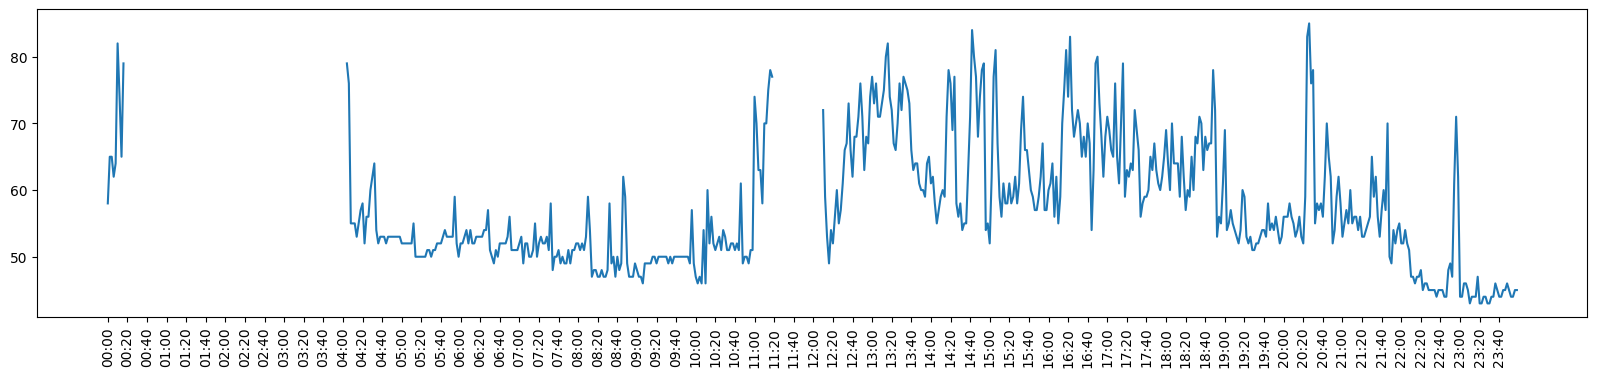

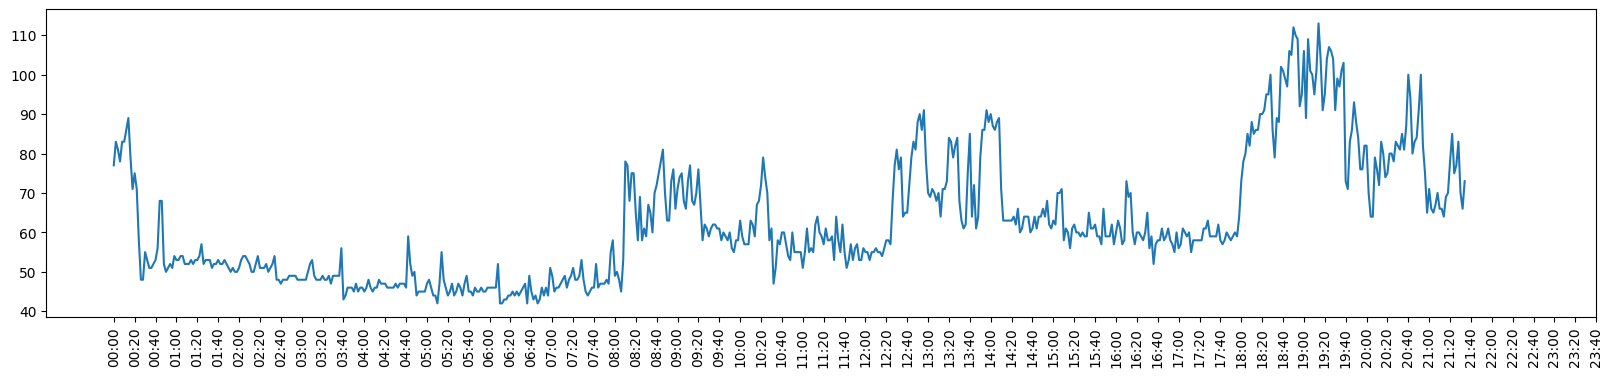

In [10]:
# Analyze problematic datasets: 2024-12-25 and 2024-12-27
def plot_missing_data(file):
    filepath = f"../../data/raw/heart_rates/{file}"
    df = pd.read_csv(filepath)

    df = df.set_index('timestamp').reindex(time_range).reset_index()

    plt.figure(figsize=(20,4))
    plt.plot(df['timestamp'], df['heart_rate'])
    xticks = [df['timestamp'][i] for i in range(0,len(df['timestamp']),10)]
    plt.xticks(xticks, rotation=90)
    plt.show()

plot_missing_data("2024-12-25.csv")
plot_missing_data("2024-12-27.csv")

##### 3. Impute Missing Values with Linear Interpolation

How does this method work?

If the two known data points are given by the coordinates *(x0,y0)* and *(x1,y1)*, the linear interpolant is the straight line between these points. For a vlue *x* in the interval *(x0,x1)*, the value *y* is given from the equation of slopes:

$$ 
\frac{y - y_0}{x - x_0} = \frac{y_1 - y_0}{x_1 - x_0},
$$

Solving this equation for *y*, which is the unknown value at *x*, gives:

$$
y = y_0 + (y_1 - y_0) \frac{x - x_0}{x_1 - x_0}
$$

Pandas iterates through the array of values and identifies known points before and after each NaN value. Then it uses the linear interpolation formula (see the formula above) to calculate the missing value.

References: <br>
https://en.wikipedia.org/wiki/Linear_interpolation <br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html

In [11]:
def interpolate(file):
    time_range = pd.date_range(start=start, end=end, freq='2min').strftime("%H:%M").tolist()
    
    filepath = f"../../data/raw/heart_rates/{file}"
    df = pd.read_csv(filepath)
    df = df.set_index('timestamp').reindex(time_range).reset_index()

    df['heart_rate'] = df['heart_rate'].interpolate(method='linear')

    return df

**Comparison Between the Dataset of 25-12-2024 before Linear Interpolation and After Interpolation**

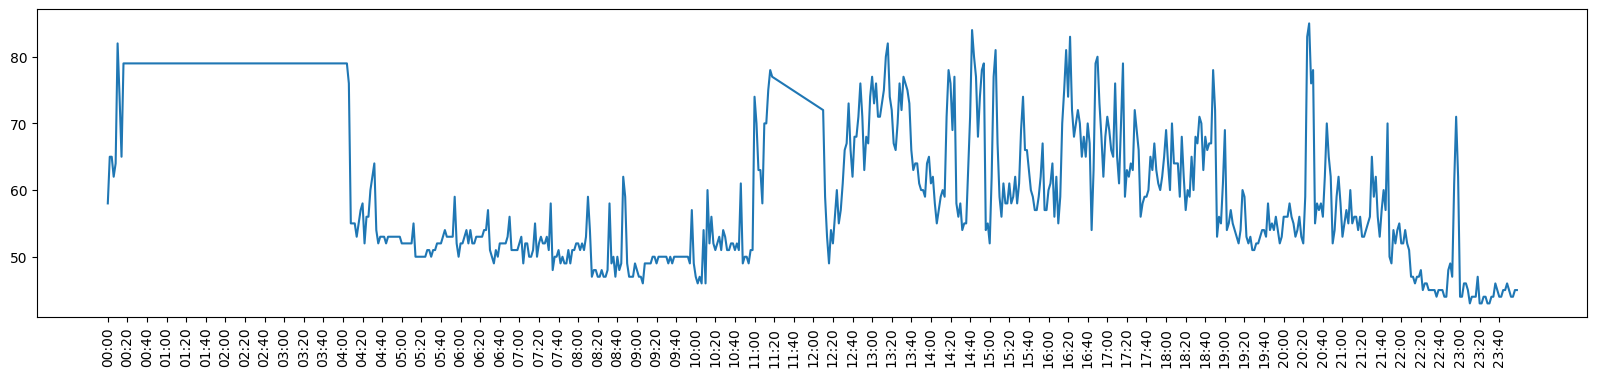

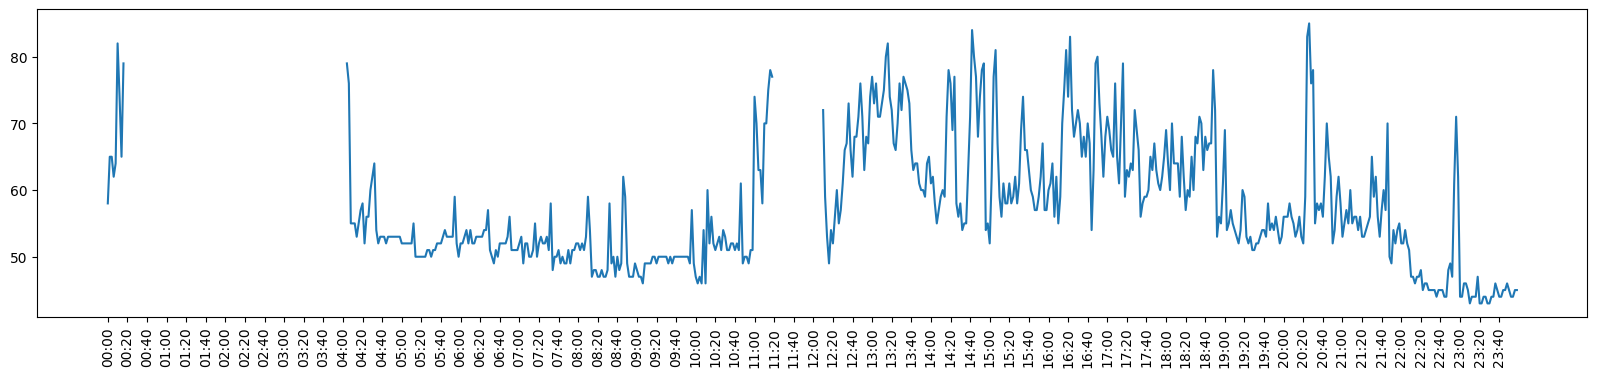

In [12]:
interpolated_df = interpolate("2024-12-25.csv")

plt.figure(figsize=(20,4))
plt.plot(interpolated_df['timestamp'], interpolated_df['heart_rate'])
xticks = [interpolated_df['timestamp'][i] for i in range(0,len(interpolated_df['timestamp']),10)]
plt.xticks(xticks, rotation=90)
plt.show()

plot_missing_data("2024-12-25.csv")

In [13]:
# Verify that each dataset has 720 not-null values after linear interpolation
all_valid_datasets = True

non_valid_datasets = []

expected_rows = 720

for file in filtered_files[1:]:
    interpolated = interpolate(file)
    nan_values = interpolated_df['heart_rate'].isnull().sum()
    if nan_values != 0:
        all_valid_datasets = False
        non_valid_datasets.append(file)

    rows = interpolated_df.shape[0]
    if rows != 720:
        all_valid_datasets = False
        if not file in non_valid_datasets:
            non_valid_datasets.append(file)
    
if all_valid_datasets:
    print("All datasets are valid.")
else:
    print("Founded problematic datasets:\n")
    for df in non_valid_datasets:
        print(df + '\n')

All datasets are valid.


##### 4. Correct Data Formats and Types

In [14]:
# interpolate all datasets and save them in data/raw/heart_rates/interpolated
output_directory = "../../data/raw/heart_rates/interpolated"
os.makedirs(output_directory, exist_ok=True)

for file in filtered_files[1:]:
    file_path = os.path.join(output_directory, file)
    interpolated = interpolate(file)

    interpolated.to_csv(file_path, index=False)

# treat 2024-12-21.csv in a different way
first_df_path = '../../data/raw/heart_rates/2024-12-21.csv'
first_df_output_path = '../../data/raw/heart_rates/interpolated/2024-12-21.csv'
first_df_interpolated = interpolate("2024-12-21.csv")
first_df_interpolated = first_df_interpolated.dropna(axis=0)
first_df_interpolated.to_csv(first_df_output_path, index=False)

In [18]:
interpolated_directory = "../../data/raw/heart_rates/interpolated"

interpolated_files = [f for f in os.listdir(interpolated_directory) if f.endswith(".csv")]
print(interpolated_files)

['2024-12-21.csv', '2024-12-22.csv', '2024-12-23.csv', '2024-12-24.csv', '2024-12-25.csv', '2024-12-26.csv', '2024-12-27.csv', '2024-12-28.csv', '2024-12-29.csv', '2024-12-30.csv', '2024-12-31.csv', '2025-01-01.csv', '2025-01-02.csv', '2025-01-03.csv', '2025-01-04.csv', '2025-01-05.csv', '2025-01-06.csv']


In [96]:
sample_file = os.path.join(interpolated_directory, interpolated_files[3])
sample_df = pd.read_csv(sample_file)

sample_df.dtypes

timestamp     object
heart_rate     int64
dtype: object

In [97]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   timestamp   720 non-null    object
 1   heart_rate  720 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB


In [98]:
# convert timestamp column into a time object for the sample dataset
sample_df['timestamp'] = pd.to_datetime(sample_df['timestamp'], format="%H:%M")

sample_df.dtypes

timestamp     datetime64[ns]
heart_rate             int64
dtype: object

In [99]:
# check the distance between consecutive timestamps (expected 2 mins)
sample_df['time_difference'] = sample_df['timestamp'].diff().dt.total_seconds() / 60

# handle the first row
sample_df.loc[0, "time_difference"] = 0

sample_df['timestamp'] = pd.to_datetime(sample_df['timestamp'], format="%H:%M").dt.time

sample_df.head()

,timestamp,heart_rate,time_difference
0,00:00:00,75,0.0
1,00:02:00,75,2.0
2,00:04:00,66,2.0
3,00:06:00,75,2.0
4,00:08:00,83,2.0


In [100]:
is_valid = (sample_df['time_difference'][1:] == 2).all()

if is_valid:
    print("All time differences are valid (2 minutes).")
else:
    print("There are rows where time_difference is not 2 minutes.")
    invalid_rows = df[df['time_difference'] != 2]
    print(invalid_rows)

All time differences are valid (2 minutes).


In [105]:
# check the distance between consecutive timestamps (expected 2 mins) for each dataset

all_valid = True
non_valid_files = []
interpolated_directory = "../../data/raw/heart_rates/interpolated"

for f in interpolated_files:
    file_path = os.path.join(interpolated_directory, f)
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format="%H:%M")
    df['time_difference'] = df['timestamp'].diff().dt.total_seconds() / 60

    is_valid = (df['time_difference'][1:] == 2).all()

    if not is_valid:
        all_valid = True
        non_valid_files.append(f)

if all_valid:
    print("For each dataset, all time differences are valid (2 minutes).")
else:
    print("Some datasets are wrong")
    for f in non_valid_files:
        print(f + '\n')

For each dataset, all time differences are valid (2 minutes).
